# Modeling the Data

In this notebook, we model our users table that we generated in the prepare_data notebook. We do this to see how accurately we can predict retainment and which factors are most important. I ended up running out of time to really build this model out so I hope it at least serves as a sense for the process.

In [8]:
# Import Libraries
import numpy             as np 
import pandas            as pd 
import matplotlib.pyplot as plt
import seaborn           as sns

In [3]:
# Load data
users = pd.read_csv('../../discord_interview_dataset/users.csv')

### Feature Selection

We could use an automated method to select features out of our larger set. For the sake of time I will just simply be selecting features that I think encapsulate the model fairly well.

In [26]:
features = [ 'retained',
             'start_listening',
             'start_speaking',     
             'read_message',
             'send_message',
             'friends',
             'guilds_created',
             'guilds_joined',
             'games_launched',
             'unique_games',
             'messages_unique_channels',
             'messages_unique_channel_types',
             'voice_ch_unique_guilds',
             'voice_ch_unique_channels',
             'voice_ch_unique_channel_types',
             'voice_ch_unique_browsers'
]

data = users[features]

**Examine Correlation Among Features**

Not surprisingly some features are highly correlated, 'start_speaking' and 'start_listening' for example. This is not good for our model as it hurts predictive power among the model's coefficients. Not ideal when we are trying to use those coefficients to understand which factors are the most important for predicting retention. For the sake of time we will move on and note this as one area for improvement in future iterations.

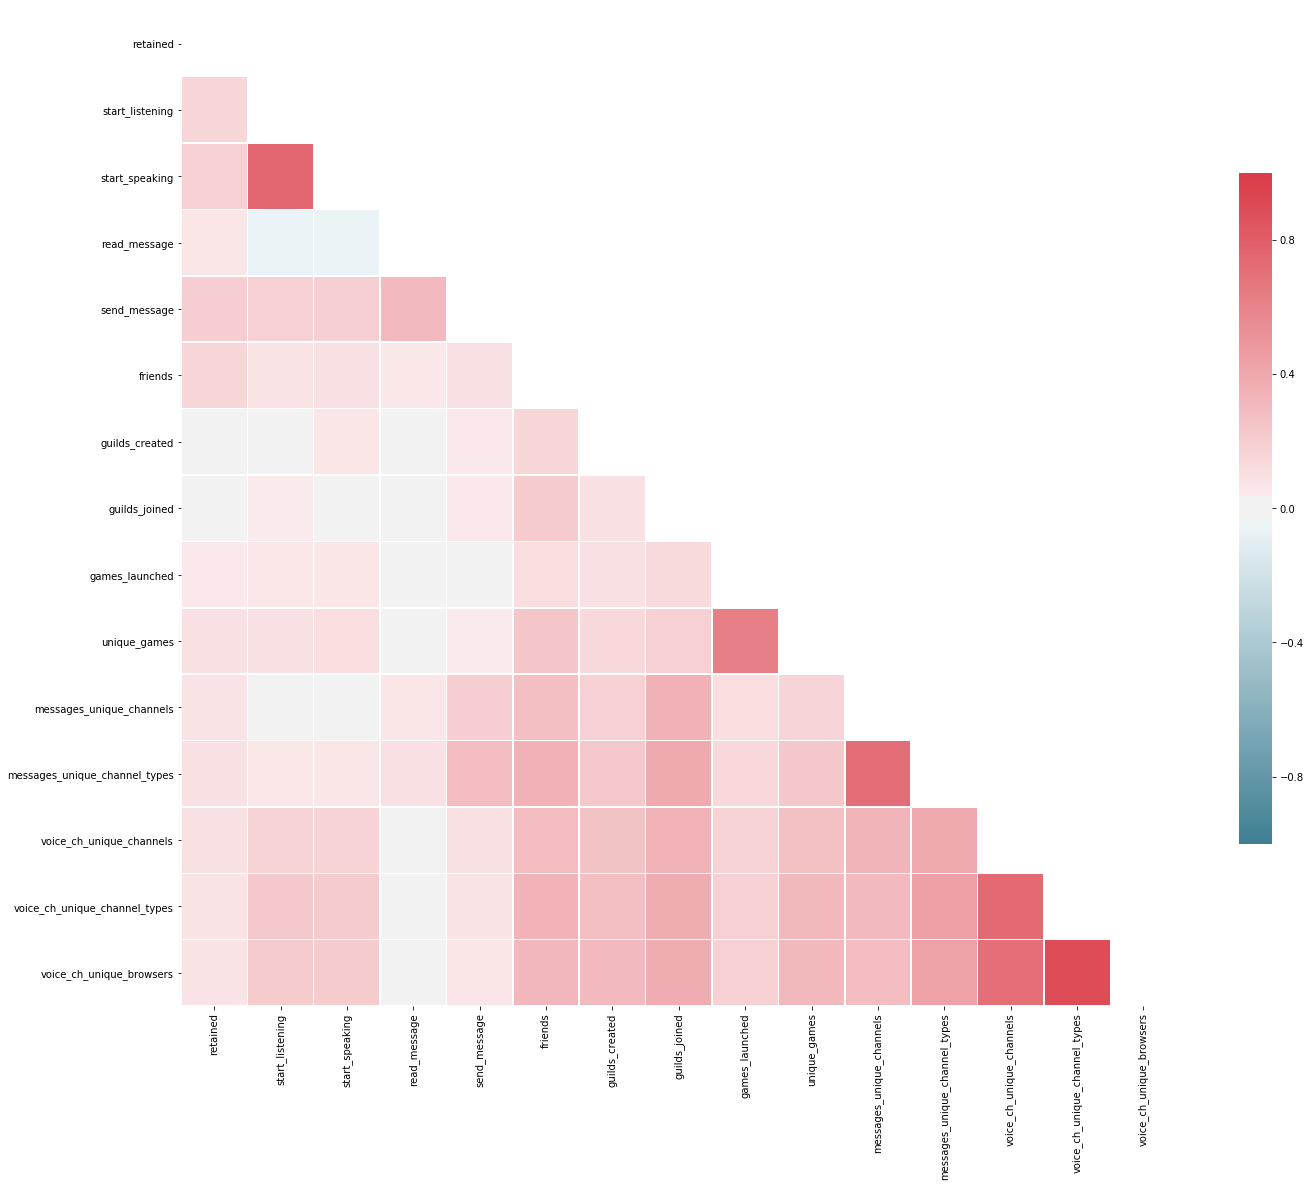

In [35]:
# Plot Correlation Matrix

# Generate and visualize the correlation matrix
corr = data.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.tight_layout()

### Initialize Models

In [27]:
# Create training data
X = data.drop('retained', axis=1)
y = data['retained']

In [28]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [32]:
# Generate Model Pipelines
from sklearn.pipeline      import Pipeline, make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble      import RandomForestClassifier

rf_pipeline  = make_pipeline(Imputer(missing_values='NaN', strategy='mean', axis=0),
                             StandardScaler(),
                             RandomForestClassifier())


log_pipeline = Pipeline(memory=None,
                        steps = [('imputer'   , Imputer(missing_values='NaN', strategy='median', axis=0)),
                                 ('classifier', LogisticRegression(class_weight='balanced', penalty="l2", C=1))]
                       )

### Run Random Forest Model

             precision    recall  f1-score   support

          0       0.66      0.63      0.64     13536
          1       0.70      0.73      0.71     16035

avg / total       0.68      0.68      0.68     29571

ROC AUC: 0.74


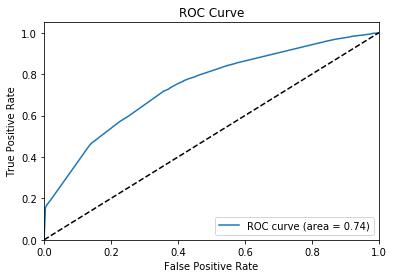

In [29]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from visualizations  import plot_roc

# 1. Random Forest Model
forest = rf_pipeline.fit(X_train, y_train)
rf_predictions = rf_pipeline.predict(X_test)

# 2. Display Classification Report & Confusion Matrix
print(classification_report(y_test, rf_predictions))

# 3. Plot ROC Curve
plot_roc(y_test, rf_pipeline.predict_proba(X_test))

In [31]:
# 4. Feature Importance
feature_importance = pd.DataFrame()
feature_importance['Features'] = list(data.drop('retained', axis=1))
feature_importance['Importance'] = rf_pipeline.steps[2][1].feature_importances_
feature_importance.sort_values('Importance', ascending=False).head(20)

,Features,Importance
3,send_message,0.186149
2,read_message,0.180963
1,start_speaking,0.145118
4,friends,0.125477
0,start_listening,0.082011
7,games_launched,0.053369
11,voice_ch_unique_channels,0.052936
6,guilds_joined,0.040828
9,messages_unique_channels,0.034872
8,unique_games,0.028047


### Run Logistic Model

             precision    recall  f1-score   support

          0       0.55      0.78      0.65     13536
          1       0.71      0.47      0.57     16035

avg / total       0.64      0.61      0.60     29571

ROC AUC: 0.66


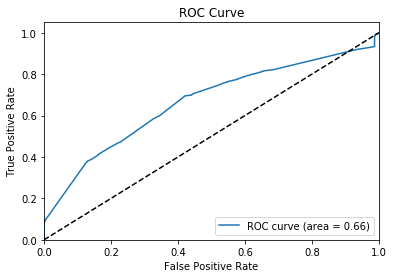

,feature,odds_ratio
0,start_listening,1.102251
1,start_speaking,1.694833
2,read_message,1.099424
3,send_message,1.996687
4,friends,305.814464
5,guilds_created,0.970669
6,guilds_joined,0.961610
7,games_launched,1.004950
8,unique_games,1.184936
9,messages_unique_channels,1.525495


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from visualizations import plot_roc

log_pipeline.fit(X_train, y_train)
log_predictions = log_pipeline.predict(X_test)

# Print Precision & Recall
print(classification_report(y_test, log_predictions))

# Print ROC Curve
plot_roc(y_test, log_pipeline.predict_proba(X_test))

# Print Feature Coefficients
classifier = log_pipeline.named_steps['classifier']
coef = classifier.coef_[0]
odds = np.exp(coef)

feature_names = X.columns.values.tolist()
feature_odds_data = pd.DataFrame({'feature': feature_names, 'odds_ratio': odds})
feature_odds_data

These models can definitely be improved but they do give us a decent idea of which factors to look at. We can say fairly confidently that friends, proactive events such as sending messages and speaking, and the number of unique channels a user visits will be important factors to look at. 